In [92]:
import numpy as np
import keras._tf_keras.keras
from keras._tf_keras.keras import backend as K
from segmentation_models import Unet
from segmentation_models import  get_preprocessing
import pandas as pd
import matplotlib.pyplot as plt
import os,gc
from PIL import Image
import warnings
warnings.filterwarnings('ignore')
os.environ["SM_FRAMEWORK"] = "tf.keras"

In [34]:
path = os.path.join(os.getcwd(),'data')
train = pd.read_csv(path + '/train.csv')
train.head()

,ImageId,ClassId,EncodedPixels
0,0002cc93b.jpg,1,29102 12 29346 24 29602 24 29858 24 30114 24 3...
1,0007a71bf.jpg,3,18661 28 18863 82 19091 110 19347 110 19603 11...
2,000a4bcdd.jpg,1,37607 3 37858 8 38108 14 38359 20 38610 25 388...
3,000f6bf48.jpg,4,131973 1 132228 4 132483 6 132738 8 132993 11 ...
4,0014fce06.jpg,3,229501 11 229741 33 229981 55 230221 77 230468...


In [137]:
train2 = train.pivot(index='ImageId', columns='ClassId', 
                     values='EncodedPixels')
train2.fillna('',inplace=True); 
train2['count'] = np.sum(train2.iloc[:,1:]!='',axis=1).values
train2.head()

ClassId,1,2,3,4,count
ImageId,,,,,
0002cc93b.jpg,29102 12 29346 24 29602 24 29858 24 30114 24 3...,,,,0
0007a71bf.jpg,,,18661 28 18863 82 19091 110 19347 110 19603 11...,,1
000a4bcdd.jpg,37607 3 37858 8 38108 14 38359 20 38610 25 388...,,,,0
000f6bf48.jpg,,,,131973 1 132228 4 132483 6 132738 8 132993 11 ...,1
0014fce06.jpg,,,229501 11 229741 33 229981 55 230221 77 230468...,,1


In [143]:
train3 = pd.DataFrame(train2.to_records())
train3.rename(columns={"1":"e1","2":"e2","3":"e3","4":"e4"}, inplace=True)
train3.head()

,ImageId,e1,e2,e3,e4,count
0,0002cc93b.jpg,29102 12 29346 24 29602 24 29858 24 30114 24 3...,,,,0
1,0007a71bf.jpg,,,18661 28 18863 82 19091 110 19347 110 19603 11...,,1
2,000a4bcdd.jpg,37607 3 37858 8 38108 14 38359 20 38610 25 388...,,,,0
3,000f6bf48.jpg,,,,131973 1 132228 4 132483 6 132738 8 132993 11 ...,1
4,0014fce06.jpg,,,229501 11 229741 33 229981 55 230221 77 230468...,,1


### Utility Function

In [144]:
def rle2maskResize(rle):
    # CONVERT RLE TO MASK 
    if (pd.isnull(rle))|(rle==''): 
        return np.zeros((128,800) ,dtype=np.uint8)
    
    height= 256
    width = 1600
    mask= np.zeros( width*height ,dtype=np.uint8)

    array = np.asarray([int(x) for x in rle.split()])
    starts = array[0::2]-1
    lengths = array[1::2]    
    for index, start in enumerate(starts):
        mask[int(start):int(start+lengths[index])] = 1
    
    return mask.reshape( (height,width), order='F' )[::2,::2]

def mask2contour(mask, width=3):
    # CONVERT MASK TO ITS CONTOUR
    w = mask.shape[1]
    h = mask.shape[0]
    mask2 = np.concatenate([mask[:,width:],np.zeros((h,width))],axis=1)
    mask2 = np.logical_xor(mask,mask2)
    mask3 = np.concatenate([mask[width:,:],np.zeros((width,w))],axis=0)
    mask3 = np.logical_xor(mask,mask3)
    return np.logical_or(mask2,mask3) 

def mask2pad(mask, pad=2):
    # ENLARGE MASK TO INCLUDE MORE SPACE AROUND DEFECT
    w = mask.shape[1]
    h = mask.shape[0]
    
    # MASK UP
    for k in range(1,pad,2):
        temp = np.concatenate([mask[k:,:],np.zeros((k,w))],axis=0)
        mask = np.logical_or(mask,temp)
    # MASK DOWN
    for k in range(1,pad,2):
        temp = np.concatenate([np.zeros((k,w)),mask[:-k,:]],axis=0)
        mask = np.logical_or(mask,temp)
    # MASK LEFT
    for k in range(1,pad,2):
        temp = np.concatenate([mask[:,k:],np.zeros((h,k))],axis=1)
        mask = np.logical_or(mask,temp)
    # MASK RIGHT
    for k in range(1,pad,2):
        temp = np.concatenate([np.zeros((h,k)),mask[:,:-k]],axis=1)
        mask = np.logical_or(mask,temp)
    
    return mask 

### Data Generator

In [154]:
class DataGenerator(keras.utils.Sequence):
    def __init__(self, df, batch_size = 16, subset="train", shuffle=False, 
                 preprocess=None, info={}):
        super().__init__()
        self.df = df
        self.shuffle = shuffle
        self.subset = subset
        self.batch_size = batch_size
        self.preprocess = preprocess
        self.info = info
        
        if self.subset == "train":
            self.data_path = path + '/train_images/'
        elif self.subset == "test":
            self.data_path = path + '/test_images/'
        self.on_epoch_end()

    def __len__(self):
        return int(np.floor(len(self.df) / self.batch_size))
    
    def on_epoch_end(self):
        self.indexes = np.arange(len(self.df))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)
    
    def __getitem__(self, index): 
        X = np.empty((self.batch_size,128,800,3),dtype=np.float32)
        y = np.empty((self.batch_size,128,800,4),dtype=np.int8)
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]
        for i,f in enumerate(self.df['ImageId'].iloc[indexes]):
            self.info[index*self.batch_size+i]=f
            X[i,] = Image.open(self.data_path + f).resize((800,128))
            if self.subset == 'train': 
                for j in range(4):
                    y[i,:,:,j] = rle2maskResize(self.df['e'+str(j+1)].iloc[indexes[i]])
        if self.preprocess!=None: X = self.preprocess(X)
        if self.subset == 'train': return X, y
        else: return X

### Train EDA

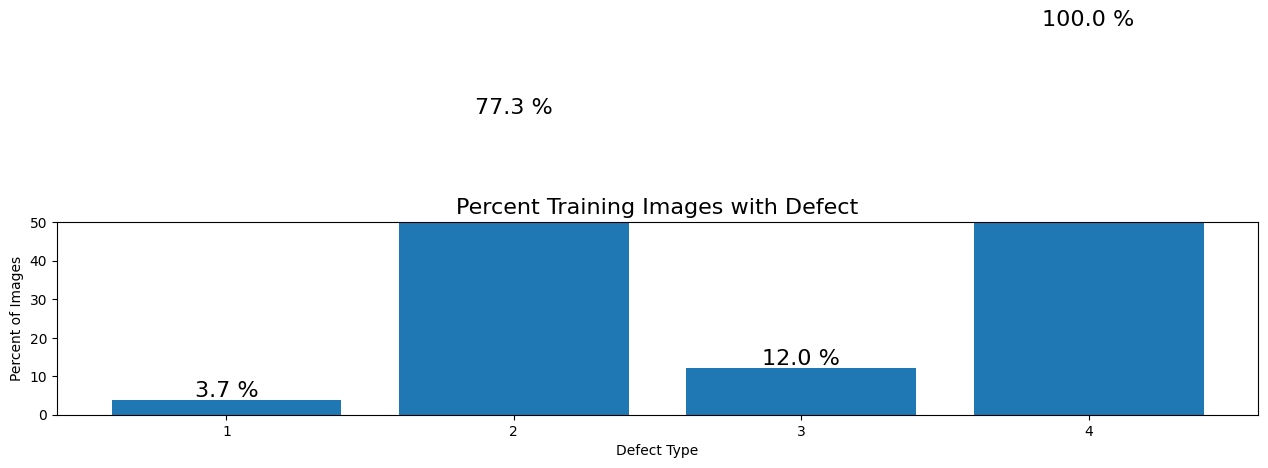

In [155]:
plt.figure(figsize=(15.5,2.5))
bar = plt.bar( [1,2,3,4],100*np.mean( train2.iloc[:,1:5]!='',axis=0) )
plt.title('Percent Training Images with Defect', fontsize=16)
plt.ylabel('Percent of Images'); plt.xlabel('Defect Type')
plt.xticks([1,2,3,4])
for rect in bar:
    height = rect.get_height()
    plt.text(rect.get_x() + rect.get_width()/2.0, height, '%.1f %%' % height,
             ha='center', va='bottom',fontsize=16)
plt.ylim((0,50)); plt.show()

Images and masks from our Data Generator
KEY: yellow=defect1, green=defect2, blue=defect3, magenta=defect4


KeyError: 12

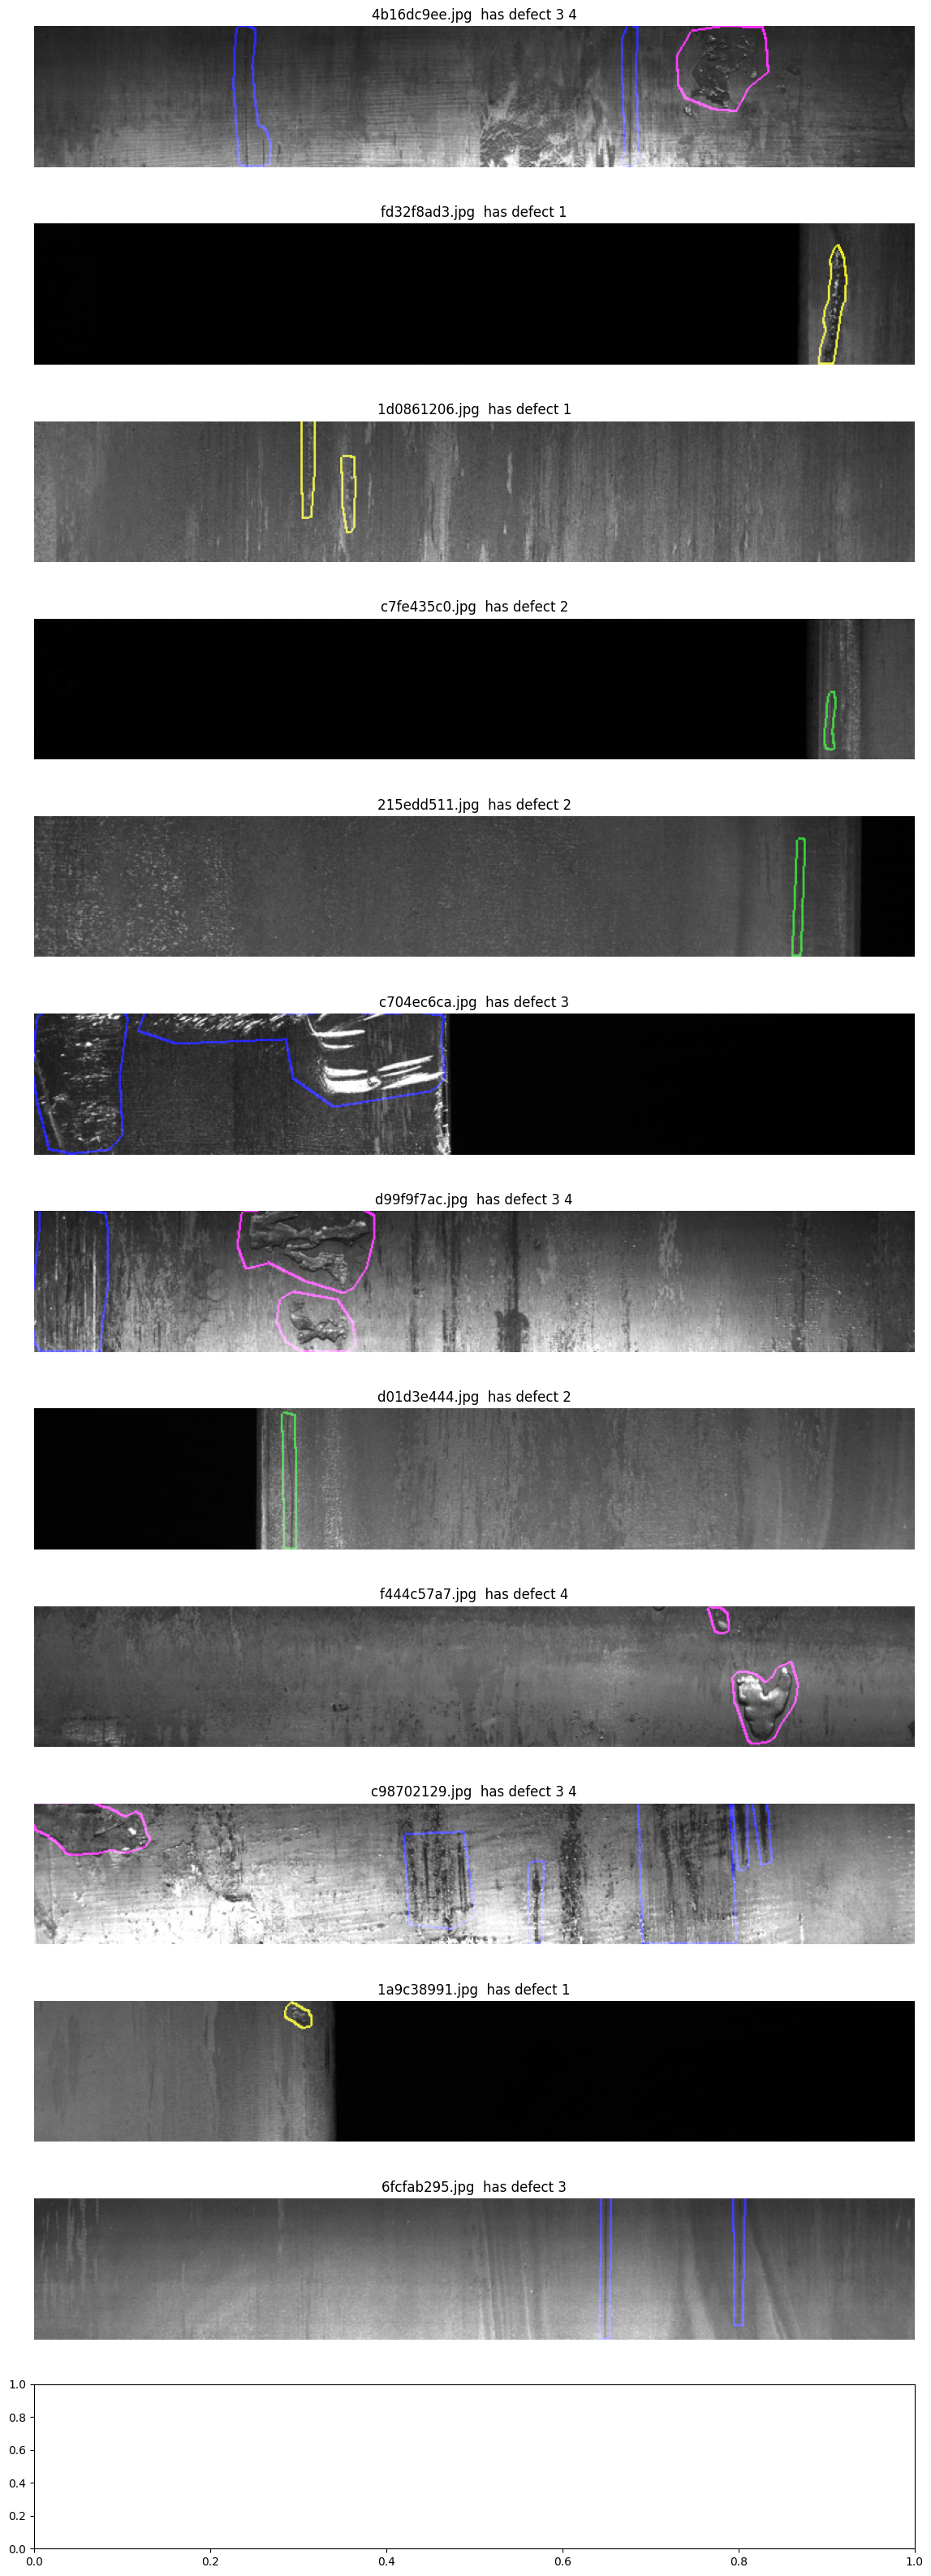

In [184]:
# DEFECTIVE IMAGE SAMPLES
filenames = {}
defects = list(train3[train3['e1']!=''].sample(3).index)
defects += list(train3[train3['e2']!=''].sample(3).index)
defects += list(train3[train3['e3']!=''].sample(3).index)
defects += list(train3[train3['e4']!=''].sample(3).index)

# DATA GENERATOR
train_batches = DataGenerator(train3[train3.index.isin(defects)],
                              shuffle=True,info=filenames)
print('Images and masks from our Data Generator')
print('KEY: yellow=defect1, green=defect2, blue=defect3, magenta=defect4')

# DISPLAY IMAGES WITH DEFECTS
for i,batch in enumerate(train_batches):
    plt.figure(figsize=(14,50)) #20,18
    for k in range(16):
        plt.subplot(16,1,k+1)
        img = batch[0][k,]
        img = Image.fromarray(img.astype('uint8'))
        img = np.array(img)
        extra = '  has defect'
        for j in range(4):
            msk = batch[1][k,:,:,j]
            msk = mask2pad(msk,pad=3)
            msk = mask2contour(msk,width=2)
            if np.sum(msk)!=0: extra += ' '+str(j+1)
            if j==0: # yellow
                img[msk==1,0] = 235 
                img[msk==1,1] = 235
            elif j==1: img[msk==1,1] = 210 # green
            elif j==2: img[msk==1,2] = 255 # blue
            elif j==3: # magenta
                img[msk==1,0] = 255
                img[msk==1,2] = 255
        plt.title(filenames[16*i+k]+extra)
        plt.axis('off') 
        plt.imshow(img)
    plt.subplots_adjust(wspace=0.05)
    plt.show()

### Download UNET

In [188]:
# COMPETITION METRIC
import tensorflow.experimental.numpy as tnp
def dice_coef(y_true, y_pred, smooth=1):
    tnp.experimental_enable_numpy_behavior(prefer_float32=True)
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)


In [189]:
# LOAD UNET WITH PRETRAINING FROM IMAGENET
preprocess = get_preprocessing('resnet34') # for resnet, img = (img-110.0)/1.0
model = Unet('resnet34', input_shape=(128, 800, 3), classes=4, activation='sigmoid')
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=[dice_coef])

In [190]:
# TRAIN AND VALIDATE MODEL
idx = int(0.8*len(train2)); 
train_batches = DataGenerator(train3.iloc[:idx],shuffle=True,
                              preprocess=preprocess)
valid_batches = DataGenerator(train3.iloc[idx:],preprocess=preprocess)
history = model.fit(train_batches, validation_data = valid_batches, epochs 
= 30, verbose=2)

Epoch 1/30


I0000 00:00:1729538648.777807   32764 service.cc:145] XLA service 0x70fcdc0030b0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1729538648.777844   32764 service.cc:153]   StreamExecutor device (0): Quadro P4000, Compute Capability 6.1
2024-10-21 21:24:09.514851: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-10-21 21:24:12.274432: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:465] Loaded cuDNN version 8903
2024-10-21 21:24:18.216310: W external/local_tsl/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 6.60GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2024-10-21 21:24:19.121142: W external/local_tsl/tsl/framework/bfc_allocator.cc:296] Allocator (GP

333/333 - 214s - 643ms/step - dice_coef: 0.4230 - loss: 0.0799 - val_dice_coef: 0.5908 - val_loss: 0.0381
Epoch 2/30
333/333 - 145s - 435ms/step - dice_coef: 0.8624 - loss: 0.0306 - val_dice_coef: 0.7317 - val_loss: 0.0376
Epoch 3/30
333/333 - 143s - 430ms/step - dice_coef: 0.9465 - loss: 0.0284 - val_dice_coef: 0.8650 - val_loss: 0.0288
Epoch 4/30
333/333 - 140s - 421ms/step - dice_coef: 1.0414 - loss: 0.0256 - val_dice_coef: 1.1491 - val_loss: 0.0276
Epoch 5/30
333/333 - 140s - 421ms/step - dice_coef: 1.0808 - loss: 0.0244 - val_dice_coef: 0.7241 - val_loss: 0.0336
Epoch 6/30
333/333 - 140s - 421ms/step - dice_coef: 1.1103 - loss: 0.0233 - val_dice_coef: 1.2062 - val_loss: 0.0252
Epoch 7/30
333/333 - 140s - 421ms/step - dice_coef: 1.1395 - loss: 0.0226 - val_dice_coef: 0.9991 - val_loss: 0.0243
Epoch 8/30
333/333 - 140s - 421ms/step - dice_coef: 1.1557 - loss: 0.0219 - val_dice_coef: 1.0280 - val_loss: 0.0250
Epoch 9/30
333/333 - 140s - 421ms/step - dice_coef: 1.2183 - loss: 0.0200 -

In [192]:
# PREDICT FROM VALIDATION SET (ONLY IMAGES WITH DEFECTS)
val_set = train3.iloc[idx:];
defects = list(val_set[val_set['e1']!=''].sample(6).index)
defects += list(val_set[val_set['e2']!=''].sample(6).index)
defects += list(val_set[val_set['e3']!=''].sample(14).index)
defects += list(val_set[val_set['e4']!=''].sample(6).index)

valid_batches = DataGenerator(val_set[val_set.index.isin(defects)],preprocess=preprocess)
preds = model.predict(valid_batches,verbose=1)

2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 94ms/step


In [ ]:
# PLOT PREDICTIONS
valid_batches = DataGenerator(val_set[val_set.index.isin(defects)])
print('Plotting predictions...')
print('KEY: yellow=defect1, green=defect2, blue=defect3, magenta=defect4')

for i,batch in enumerate(valid_batches):
    plt.figure(figsize=(20,36))
    for k in range(16):
        plt.subplot(16,2,2*k+1)
        img = batch[0][k,]
        img = Image.fromarray(img.astype('uint8'))
        img = np.array(img)
        dft = 0
        extra = '  has defect '
        for j in range(4):
            msk = batch[1][k,:,:,j]
            if np.sum(msk)!=0: 
                dft=j+1
                extra += ' '+str(j+1)
            msk = mask2pad(msk,pad=2)
            msk = mask2contour(msk,width=3)
            if j==0: # yellow
                img[msk==1,0] = 235 
                img[msk==1,1] = 235
            elif j==1: img[msk==1,1] = 210 # green
            elif j==2: img[msk==1,2] = 255 # blue
            elif j==3: # magenta
                img[msk==1,0] = 255
                img[msk==1,2] = 255
        if extra=='  has defect ': extra =''
        plt.title('Train '+train2.iloc[16*i+k,0]+extra)
        plt.axis('off') 
        plt.imshow(img)
        plt.subplot(16,2,2*k+2) 
        # if dft!=0:
        #     msk = preds[12*i+k,:,:,dft-1]
        #     plt.imshow(msk)
        # else:
        #     plt.imshow(np.zeros((128,800)))
        # plt.axis('off')
        # mx = np.round(np.max(msk),3)
        # plt.title('Predict Defect '+str(dft)+'  (max pixel = '+str(mx)+')')
    plt.subplots_adjust(wspace=0.05)
    plt.show()